<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/02_GNN_message_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks: Message Passing and Permutation Equivariance




## Setup and Installation
First, we'll install the required libraries. We'll need:

RDKit: For molecular manipulation and cheminformatics
PyTorch Geometric: For graph neural network implementations
Matplotlib & Seaborn: For visualization

In [2]:
# @title install required libraries
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 14.5 MB/s eta 0:00:00


In [9]:
# @title import required libraries
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
from matplotlib.animation import FuncAnimation
import numpy as np # array manipulation
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw # chemical processing
import networkx as nx # visualization
from IPython.display import HTML

## Learning Objectives
After completing this chapter, you should be able to:
- Describe what message passing is in a Graph Neural Network (GNN)
- Understand permutation equivariance and permutation invariance
- Visualize how message passing works on molecular graphs
- Explain why GNNs are suitable for molecular property prediction

## Introduction to Graph Neural Networks

A graph neural network (GNN) is a neural network with two defining attributes:
1. Its input is a graph
2. Its output is permutation equivariant

The first point is straightforward - a GNN processes data in graph format (nodes connected by edges).

But what does "permutation equivariant" mean? In our molecular context, a permutation means re-ordering our atoms (nodes). For example, in methanol, we could re-number the atoms differently. Our goal is to ensure the GNN's output changes correspondingly with these renumberings.

## Understanding Permutation Equivariance

Let's first understand what permutation equivariance and invariance mean:

- **Permutation Equivariance**: If you reorder the input nodes, the output changes in the same way.
- **Permutation Invariance**: If you reorder the input nodes, the output remains unchanged.

When modeling atom-level properties (like partial charges), we need permutation equivariance. When modeling molecule-level properties (like solubility), we need permutation invariance.

In [4]:
# Define atom indices for methanol
my_elements = {6: "C", 8: "O", 1: "H"}

def smiles2graph(sml):
    """Convert a SMILES string to a graph representation"""
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

Let's create a graph for methanol (CH₃OH):


In [5]:
# Create a graph for methanol
nodes, adj = smiles2graph("CO")
print(f"Node features shape: {nodes.shape}")
print(f"Adjacency matrix shape: {adj.shape}")

# Display the adjacency matrix (summing over bond types)
adj_sum = np.sum(adj, axis=2)
print("\nAdjacency matrix for methanol:")
print(adj_sum)

Node features shape: (6, 3)
Adjacency matrix shape: (6, 6, 5)

Adjacency matrix for methanol:
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Visualizing Message Passing

Message passing is the core operation in GNNs. During message passing:
1. Each node collects information from its neighbors
2. This information is transformed using learnable weights
3. The node updates its representation based on this aggregated information

Let's visualize this process for methanol:

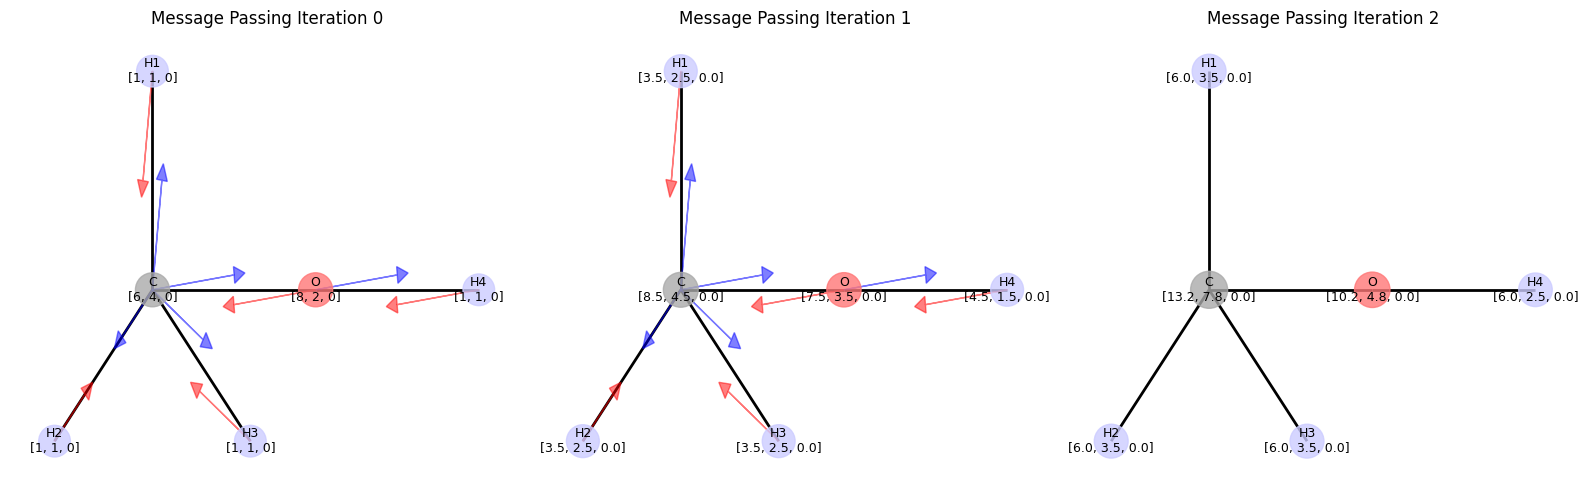

In [10]:
# Create a visualization of message passing
def visualize_message_passing():
    # Define atom positions for methanol
    pos = {
        'C': np.array([0, 0]),
        'O': np.array([1.5, 0]),
        'H1': np.array([0, 1.3]),
        'H2': np.array([-0.9, -0.9]),
        'H3': np.array([0.9, -0.9]),
        'H4': np.array([3.0, 0])
    }

    # Define atom colors
    atom_colors = {
        'C': '#AAAAAA',  # gray
        'O': '#FF7777',  # red
        'H1': '#CCCCFF',  # light blue
        'H2': '#CCCCFF',  # light blue
        'H3': '#CCCCFF',  # light blue
        'H4': '#CCCCFF'   # light blue
    }

    # Define initial node feature vectors (simplified for visualization)
    initial_features = {
        'C': [6, 4, 0],   # Atomic number, valence, charge
        'O': [8, 2, 0],
        'H1': [1, 1, 0],
        'H2': [1, 1, 0],
        'H3': [1, 1, 0],
        'H4': [1, 1, 0]
    }

    # Create a graph for methanol
    G = nx.Graph()

    # Add nodes with features
    for atom, features in initial_features.items():
        G.add_node(atom, features=features, layer=0)

    # Add edges (bonds)
    G.add_edges_from([('C', 'O'), ('O', 'H4'), ('C', 'H1'), ('C', 'H2'), ('C', 'H3')])

    # Define message passing function (simplified)
    def message_passing(G, num_iterations=2):
        """Perform message passing on the graph for a given number of iterations"""
        graphs = [G.copy()]

        for iteration in range(num_iterations):
            new_G = G.copy()

            # For each node, aggregate messages from neighbors
            for node in G.nodes():
                neighbors = list(G.neighbors(node))

                # Get neighbor features
                neighbor_features = [G.nodes[neighbor]['features'] for neighbor in neighbors]

                # Simple aggregation: sum of neighbor features
                if neighbor_features:
                    aggregated = np.sum(neighbor_features, axis=0)

                    # Update node features with a simple combination of old features and neighbor info
                    old_features = np.array(G.nodes[node]['features'])
                    new_features = 0.5 * old_features + 0.5 * aggregated
                    new_G.nodes[node]['features'] = new_features.tolist()
                    new_G.nodes[node]['layer'] = iteration + 1

            G = new_G
            graphs.append(G.copy())

        return graphs

    # Perform message passing for 2 iterations
    message_passed_graphs = message_passing(G, num_iterations=2)

    # Visualization function for a specific iteration
    def visualize_message_passing_at_iteration(iteration, ax, show_messages=True):
        """Visualize the graph at a specific message passing iteration"""
        current_G = message_passed_graphs[iteration]
        next_G = message_passed_graphs[min(iteration+1, len(message_passed_graphs)-1)]

        # Clear the axis
        ax.clear()

        # Draw nodes with size based on feature magnitude
        sizes = []
        node_colors = []
        for node in current_G.nodes():
            # Node size based on the sum of feature values
            size = 500 + 100 * np.sum(current_G.nodes[node]['features']) / 10
            sizes.append(size)
            node_colors.append(atom_colors[node])

        # Draw the graph with the current positions
        nx.draw_networkx_nodes(current_G, pos, ax=ax, node_size=sizes, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(current_G, pos, ax=ax, width=2)

        # Draw node labels
        labels = {}
        for node in current_G.nodes():
            layer = current_G.nodes[node]['layer']
            features = [round(f, 1) for f in current_G.nodes[node]['features']]
            labels[node] = f"{node}\n{features}"

        nx.draw_networkx_labels(current_G, pos, labels=labels, font_size=9, ax=ax)

        # Show message passing arrows if requested and not at the last iteration
        if show_messages and iteration < len(message_passed_graphs) - 1:
            for edge in current_G.edges():
                source, target = edge
                source_pos, target_pos = pos[source], pos[target]

                # Draw arrows in both directions for bidirectional message passing
                # Calculate midpoints and shift slightly to avoid overlap
                mid = (source_pos + target_pos) / 2
                offset1 = np.array([0.1, 0.1])
                offset2 = np.array([-0.1, -0.1])

                # Draw arrow from source to target
                ax.arrow(source_pos[0], source_pos[1],
                        (mid + offset1)[0] - source_pos[0], (mid + offset1)[1] - source_pos[1],
                        head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.5,
                        length_includes_head=True)

                # Draw arrow from target to source
                ax.arrow(target_pos[0], target_pos[1],
                        (mid + offset2)[0] - target_pos[0], (mid + offset2)[1] - target_pos[1],
                        head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.5,
                        length_includes_head=True)

        ax.set_title(f'Message Passing Iteration {iteration}')
        ax.axis('off')

    # Create a function to display multiple iterations
    def visualize_all_iterations(iterations=3):
        fig, axes = plt.subplots(1, iterations, figsize=(16, 5))

        for i in range(iterations):
            if iterations == 1:
                ax = axes
            else:
                ax = axes[i]
            visualize_message_passing_at_iteration(i, ax, show_messages=(i < iterations-1))

        plt.tight_layout()
        plt.show()

    # Display iterations 0, 1, and 2
    visualize_all_iterations(iterations=3)

    # Create an animation for a more dynamic visualization
    def create_animation():
        fig, ax = plt.subplots(figsize=(8, 6))

        def update(frame):
            ax.clear()
            visualize_message_passing_at_iteration(frame % 3, ax)
            return ax,

        ani = FuncAnimation(fig, update, frames=3, interval=1500, blit=False)
        plt.close()  # Don't display the figure
        return ani

    # Create and display the animation
    animation = create_animation()
    return HTML(animation.to_jshtml())

# Run the visualization
visualize_message_passing()

## Demonstrating Permutation Equivariance

Now, let's demonstrate permutation equivariance by showing how reordering nodes doesn't change the essential relationships:

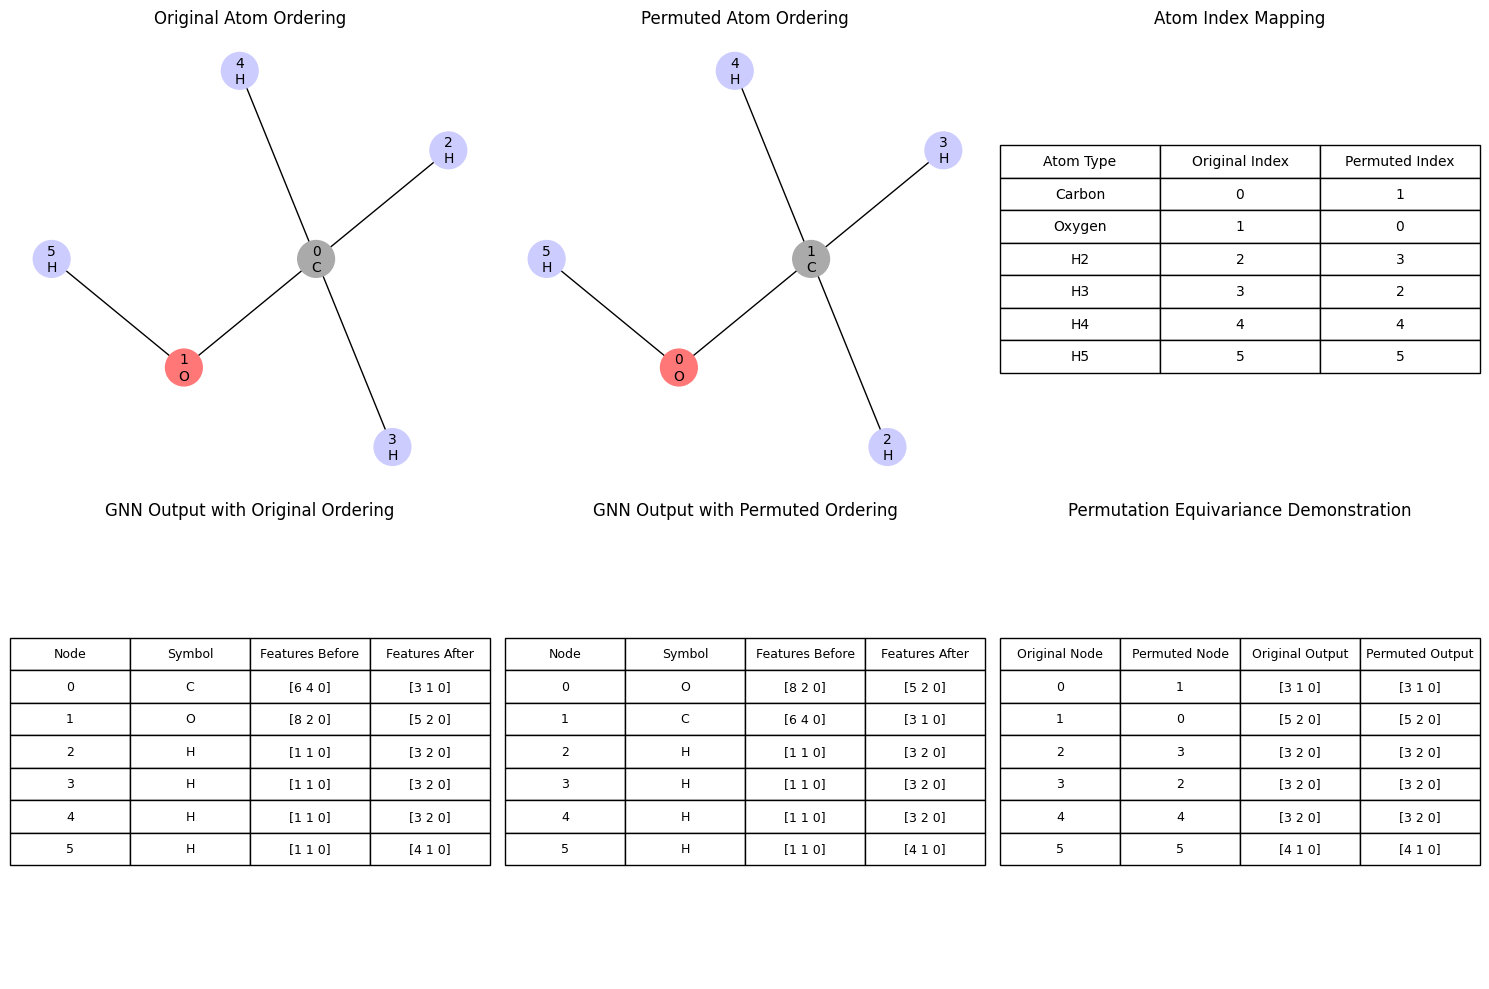


Explanation of Permutation Equivariance:
----------------------------------------
A graph neural network is permutation equivariant if reordering the input nodes
causes the output to be reordered in the same way.

Mathematically, if P is a permutation matrix and f is our GNN function:
f(P·X) = P·f(X)

In our demonstration:
1. We reordered the atoms (nodes) using permutation P
2. Applied the same GNN layer to both orderings
3. Verified that the outputs maintain the same relationship:
   - For any original node i and its permuted position p(i)
   - original_output[i] equals permuted_output[p(i)]

This property is crucial for molecular representation learning, as it ensures
that the model predictions depend only on the molecular structure,
not on the arbitrary ordering of atoms in the input representation.


In [13]:
def demonstrate_permutation_equivariance():
    """
    Demonstrates permutation equivariance by showing how node features change
    when we reorder atoms, while maintaining the same structural relationships.
    """
    # Create a methanol molecule
    mol = rdkit.Chem.MolFromSmiles("CO")
    mol = rdkit.Chem.AddHs(mol)

    # Define two different atom orderings
    # Original ordering
    original_order = list(range(mol.GetNumAtoms()))

    # Create a permutation (swap some atoms)
    permuted_order = original_order.copy()
    # Swap carbon (index 0) with oxygen (index 1)
    permuted_order[0], permuted_order[1] = permuted_order[1], permuted_order[0]
    # Swap some hydrogens too
    if len(permuted_order) > 3:
        permuted_order[2], permuted_order[3] = permuted_order[3], permuted_order[2]

    # Create simple node features based on atom properties
    atom_features = []
    for atom in mol.GetAtoms():
        # Use atomic number, degree, and formal charge as features
        features = [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge()]
        atom_features.append(features)

    original_features = np.array(atom_features)

    # Create the permuted features by reordering
    permuted_features = np.array([atom_features[i] for i in permuted_order])

    # Define a simple GNN message passing step (using identity weights for simplicity)
    def simple_gnn_layer(features, adjacency, order):
        """Simple GNN layer that aggregates neighbor features"""
        # Create adjacency matrix for the given atom ordering
        n = len(order)
        adj = np.zeros((n, n))

        # Fill adjacency matrix based on bonds
        for bond in mol.GetBonds():
            i = order.index(bond.GetBeginAtomIdx())
            j = order.index(bond.GetEndAtomIdx())
            adj[i, j] = adj[j, i] = 1

        # Message passing: For each node, average its neighbors' features
        output = np.zeros_like(features)
        for i in range(n):
            neighbors = [j for j in range(n) if adj[i, j] > 0]
            if neighbors:
                # Add self-loop
                neighbors.append(i)
                # Average the features (including self)
                output[i] = np.mean([features[j] for j in neighbors], axis=0)
            else:
                output[i] = features[i]

        return output, adj

    # Apply GNN layer to both orderings
    original_output, original_adj = simple_gnn_layer(original_features, None, original_order)
    permuted_output, permuted_adj = simple_gnn_layer(permuted_features, None, permuted_order)

    # Verify permutation equivariance: output[p_i] should equal p_output[i]
    permuted_back = np.zeros_like(permuted_output)
    for i, p_i in enumerate(permuted_order):
        permuted_back[p_i] = permuted_output[i]

    # Create a visualization
    fig = plt.figure(figsize=(15, 10))

    # 1. Original molecule visualization
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    # Generate atom coordinates for visualization
    rdkit.Chem.rdDepictor.Compute2DCoords(mol)

    # Create a NetworkX graph for the original ordering
    G_orig = nx.Graph()

    # Add nodes with position information
    pos_orig = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos = mol.GetConformer().GetAtomPosition(i)
        pos_orig[i] = np.array([pos.x, pos.y])
        atom_sym = atom.GetSymbol()
        G_orig.add_node(i, symbol=atom_sym, features=original_features[i])

    # Add edges
    for bond in mol.GetBonds():
        G_orig.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    # Draw the graph
    node_labels = {i: f"{i}\n{G_orig.nodes[i]['symbol']}" for i in G_orig.nodes()}
    node_colors = ['#AAAAAA' if G_orig.nodes[i]['symbol'] == 'C' else
                   '#FF7777' if G_orig.nodes[i]['symbol'] == 'O' else
                   '#CCCCFF' for i in G_orig.nodes()]

    nx.draw_networkx(G_orig, pos=pos_orig, labels=node_labels,
                    node_color=node_colors, node_size=700, font_size=10, ax=ax1)
    ax1.set_title("Original Atom Ordering")
    ax1.axis('off')

    # 2. Permuted molecule visualization
    ax2 = plt.subplot2grid((2, 3), (0, 1))

    # Create a NetworkX graph for the permuted ordering
    G_perm = nx.Graph()

    # Add nodes with position information (permuted)
    pos_perm = {}
    for new_idx, old_idx in enumerate(permuted_order):
        pos = mol.GetConformer().GetAtomPosition(old_idx)
        pos_perm[new_idx] = np.array([pos.x, pos.y])
        atom_sym = mol.GetAtomWithIdx(old_idx).GetSymbol()
        G_perm.add_node(new_idx, symbol=atom_sym, features=permuted_features[new_idx])

    # Add edges (permuted)
    for bond in mol.GetBonds():
        old_begin = bond.GetBeginAtomIdx()
        old_end = bond.GetEndAtomIdx()
        new_begin = permuted_order.index(old_begin)
        new_end = permuted_order.index(old_end)
        G_perm.add_edge(new_begin, new_end)

    # Draw the graph
    node_labels = {i: f"{i}\n{G_perm.nodes[i]['symbol']}" for i in G_perm.nodes()}
    node_colors = ['#AAAAAA' if G_perm.nodes[i]['symbol'] == 'C' else
                   '#FF7777' if G_perm.nodes[i]['symbol'] == 'O' else
                   '#CCCCFF' for i in G_perm.nodes()]

    nx.draw_networkx(G_perm, pos=pos_perm, labels=node_labels,
                    node_color=node_colors, node_size=700, font_size=10, ax=ax2)
    ax2.set_title("Permuted Atom Ordering")
    ax2.axis('off')

    # 3. Table showing how features transform with permutation
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    ax3.axis('tight')
    ax3.axis('off')

    feature_table = [
        ["Atom Type", "Original Index", "Permuted Index"],
        ["Carbon", f"{original_order.index(0)}", f"{permuted_order.index(0)}"],
        ["Oxygen", f"{original_order.index(1)}", f"{permuted_order.index(1)}"]
    ]

    for i in range(2, len(original_order)):
        atom_sym = mol.GetAtomWithIdx(i).GetSymbol()
        feature_table.append([f"{atom_sym}{i}", f"{original_order.index(i)}", f"{permuted_order.index(i)}"])

    table = ax3.table(cellText=feature_table, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax3.set_title("Atom Index Mapping")

    # 4. Original output features after GNN layer
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    ax4.axis('tight')
    ax4.axis('off')

    output_headers = ["Node", "Symbol", "Features Before", "Features After"]
    output_table = []

    for i in original_order:
        atom_sym = mol.GetAtomWithIdx(i).GetSymbol()
        before = str(original_features[i])
        after = str(np.round(original_output[i], 2))
        output_table.append([str(i), atom_sym, before, after])

    table = ax4.table(cellText=output_table, colLabels=output_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title("GNN Output with Original Ordering")

    # 5. Permuted output features after GNN layer
    ax5 = plt.subplot2grid((2, 3), (1, 1))
    ax5.axis('tight')
    ax5.axis('off')

    permuted_table = []
    for i, old_i in enumerate(permuted_order):
        atom_sym = mol.GetAtomWithIdx(old_i).GetSymbol()
        before = str(permuted_features[i])
        after = str(np.round(permuted_output[i], 2))
        permuted_table.append([str(i), atom_sym, before, after])

    table = ax5.table(cellText=permuted_table, colLabels=output_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax5.set_title("GNN Output with Permuted Ordering")

    # 6. Showing equivariance property
    ax6 = plt.subplot2grid((2, 3), (1, 2))
    ax6.axis('tight')
    ax6.axis('off')

    # Show that permuted_output[p(i)] = original_output[i]
    equiv_headers = ["Original Node", "Permuted Node", "Original Output", "Permuted Output"]
    equiv_table = []

    for orig_idx in original_order:
        perm_idx = permuted_order.index(orig_idx)
        orig_out = str(np.round(original_output[orig_idx], 2))
        perm_out = str(np.round(permuted_output[perm_idx], 2))
        equiv_table.append([str(orig_idx), str(perm_idx), orig_out, perm_out])

    table = ax6.table(cellText=equiv_table, colLabels=equiv_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax6.set_title("Permutation Equivariance Demonstration")

    plt.tight_layout()
    plt.show()

    # Explain permutation equivariance
    print("\nExplanation of Permutation Equivariance:")
    print("----------------------------------------")
    print("A graph neural network is permutation equivariant if reordering the input nodes")
    print("causes the output to be reordered in the same way.")
    print("\nMathematically, if P is a permutation matrix and f is our GNN function:")
    print("f(P·X) = P·f(X)")
    print("\nIn our demonstration:")
    print("1. We reordered the atoms (nodes) using permutation P")
    print("2. Applied the same GNN layer to both orderings")
    print("3. Verified that the outputs maintain the same relationship:")
    print("   - For any original node i and its permuted position p(i)")
    print("   - original_output[i] equals permuted_output[p(i)]")
    print("\nThis property is crucial for molecular representation learning, as it ensures")
    print("that the model predictions depend only on the molecular structure,")
    print("not on the arbitrary ordering of atoms in the input representation.")

# Run the demonstration
demonstrate_permutation_equivariance()

## The Kipf & Welling Graph Convolutional Network (GCN)


One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN.
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/).

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$. The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{kl}\right)
$$

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to "communicate" between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors. For chemistry, this is not satisfactory. You can stack multiple layers though. If you have two layers, the output for node $i$ will include information about node $i$'s neighbors' neighbors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation equivariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features. A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

Let's examine the Kipf & Welling GCN, one of the first popular GNN architectures:

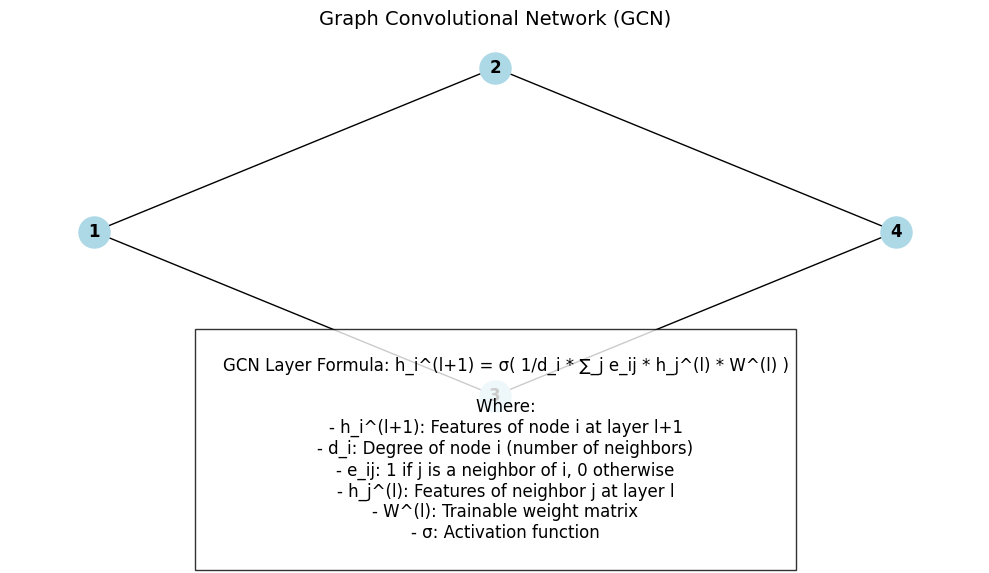

In [12]:
def explain_gcn():
    # Create a visual explanation of the GCN layer
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw a simple graph
    G = nx.Graph()
    G.add_nodes_from([1, 2, 3, 4])
    G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

    pos = {
        1: np.array([0, 0]),
        2: np.array([1, 1]),
        3: np.array([1, -1]),
        4: np.array([2, 0])
    }

    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', ax=ax)

    # Add text explaining the GCN
    text = """
    GCN Layer Formula: h_i^(l+1) = σ( 1/d_i * ∑_j e_ij * h_j^(l) * W^(l) )

    Where:
    - h_i^(l+1): Features of node i at layer l+1
    - d_i: Degree of node i (number of neighbors)
    - e_ij: 1 if j is a neighbor of i, 0 otherwise
    - h_j^(l): Features of neighbor j at layer l
    - W^(l): Trainable weight matrix
    - σ: Activation function
    """

    plt.figtext(0.5, 0.01, text, ha='center', fontsize=12, bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})
    ax.set_title("Graph Convolutional Network (GCN)", fontsize=14)
    plt.tight_layout(rect=[0, 0.2, 1, 0.95])
    plt.show()

# Explain the GCN
explain_gcn()

In [ ]:
my_elements = { 6: "C",  8: "O", 1: "H"}

In [ ]:
def smiles2graph(sml):
    """Argument for the smiles2graph function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [ ]:
nodes, adj = smiles2graph("CO")

### Exercise

Let's repeat the same process for Ethanol `(CCO)`.

1. Convert the smiles into the graph.
2. How many nodes the graph contain? What is the number of rows and columns for the graph?
3. Show the adjancy matrix for the Ethanol
4. show the adjacancy list for ethanol
5. Perform one-step of message passing for each atom in this molecules. Consider the identity matrix for weights.

## Conclusion

In this tutorial, we've explored:

1. The concept of Graph Neural Networks (GNNs) for molecular property prediction
2. Permutation equivariance and its importance in GNNs
3. Message passing as the core mechanism behind GNNs
4. The Kipf & Welling GCN architecture
5. Applied these concepts to methanol and ethanol examples

GNNs are powerful tools for chemical property prediction because they:
- Naturally represent molecular structure
- Are invariant to atom ordering
- Can capture local and global graph structure
- Learn meaningful atom and bond representations